In [1]:
library(dplyr)
library(tidyr)
library(readxl)
library(purrr)
library(stringr)
library(ggplot2)
library(zoo)
library(rlang)
library(modelsummary)
library(stargazer)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'rlang'


The following objects are masked from 'package:purrr':

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl,
    flatten_raw, invoke, splice


`modelsummary` 2.0.0 now uses `tinytable` as its default table-drawing
  backend. Learn more at: https://vincentarelbundock.github.io/tinytable/

Revert to `kableExtra` for one session:

  options(modelsummary_factory_default = 'kableExtra')
  options(modelsummary_factory_latex = 'kableExtra')
  options(modelsummary_factory_html = 'kableExtra')

Silence this message forever:

  config_modelsummary(startup_message = FALSE)


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted

In [2]:
#(a)1

master <- read.csv("../cleaning/master.csv")

na_counts <- colSums(is.na(master))
print(na_counts)

                       X                   unitid                     year 
                       0                        0                        0 
          instatetuition                    costs                  faculty 
                       3                        0                        0 
        white_cohortsize                   instnm                 semester 
                       6                      731                      731 
                 quarter          transition_year             introduction 
                     731                     1377                      731 
           totcohortsize             w_cohortsize             m_cohortsize 
                     731                      731                      731 
             tot4yrgrads               m_4yrgrads               w_4yrgrads 
                     731                      731                      731 
      women_gradrate_4yr women_gradrate_4yr_scale         men_gradrate_4yr 
            

In [3]:
#2

variables <- c("semester", "total_gradrate_4yr",
               "women_gradrate_4yr", "men_gradrate_4yr",
               "totcohortsize", "instatetuition", "costs")

#統計量を計算する関数を定義
calculate_statistics <- function(data, var, suffix) {
  data %>%
    summarize(mean = round(mean(.data[[var]], na.rm = TRUE), 3),
              sd = round(sd(.data[[var]], na.rm = TRUE), 3),
              count = sum(!is.na(.data[[var]]))) %>%
    mutate(variable = var) %>%
    rename_with(~paste0(., suffix), -variable)
}

#全体の結果を計算
results_all <- lapply(variables, function(var) {
  calculate_statistics(master, var, "")
})
summary_table_all <- bind_rows(results_all) %>%
  arrange(variable)

#introductionが1の場合の結果を計算
results_intro_1 <- lapply(variables, function(var) {
  calculate_statistics(master %>% filter(introduction == 1), var, "_1")
})
summary_table_intro_1 <- bind_rows(results_intro_1) %>%
  arrange(variable)

#introductionが0の場合の結果を計算
results_intro_0 <- lapply(variables, function(var) {
  calculate_statistics(master %>% filter(introduction == 0), var, "_0")
})
summary_table_intro_0 <- bind_rows(results_intro_0) %>%
  arrange(variable)

#各結果をvariableをキーとして結合
summary_table <- summary_table_all %>%
  left_join(summary_table_intro_1, by = "variable") %>%
  left_join(summary_table_intro_0, by = "variable")

#variable列を先頭に移動
summary_table <- summary_table %>%
  relocate(variable)

summary_table

variable,mean,sd,count,mean_1,sd_1,count_1,mean_0,sd_0,count_0
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
costs,188.965,394.298,14620,179.077,363.428,12932,368.052,714.702,957
instatetuition,10914.027,9065.628,14617,11280.608,9169.654,12932,8492.032,8949.526,957
men_gradrate_4yr,31.849,22.644,13824,32.054,22.593,12867,29.093,23.150,957
semester,0.931,0.253,13889,1.000,0.000,12932,0.000,0.000,957
total_gradrate_4yr,37.059,22.585,13889,37.309,22.518,12932,33.676,23.223,957
totcohortsize,1099.446,1183.032,13889,1069.733,1163.319,12932,1500.969,1361.365,957
women_gradrate_4yr,41.224,23.008,13865,41.470,22.939,12908,37.908,23.684,957


In [4]:
#3・4

#各年度のtotal_gradrate_4yrとsemester導入率を計算
figure_1 <- master %>%
  group_by(year) %>%
  summarize(
    avg_total_gradrate_4yr = mean(total_gradrate_4yr, na.rm = TRUE),
    semester_rate = mean(semester == 1, na.rm = TRUE)
  )

#欠損値を線形補間
summary_figure_1 <- figure_1 %>%
  mutate(
    avg_total_gradrate_4yr = na.approx(avg_total_gradrate_4yr, na.rm = FALSE),
    semester_rate = na.approx(semester_rate, na.rm = FALSE)
  )

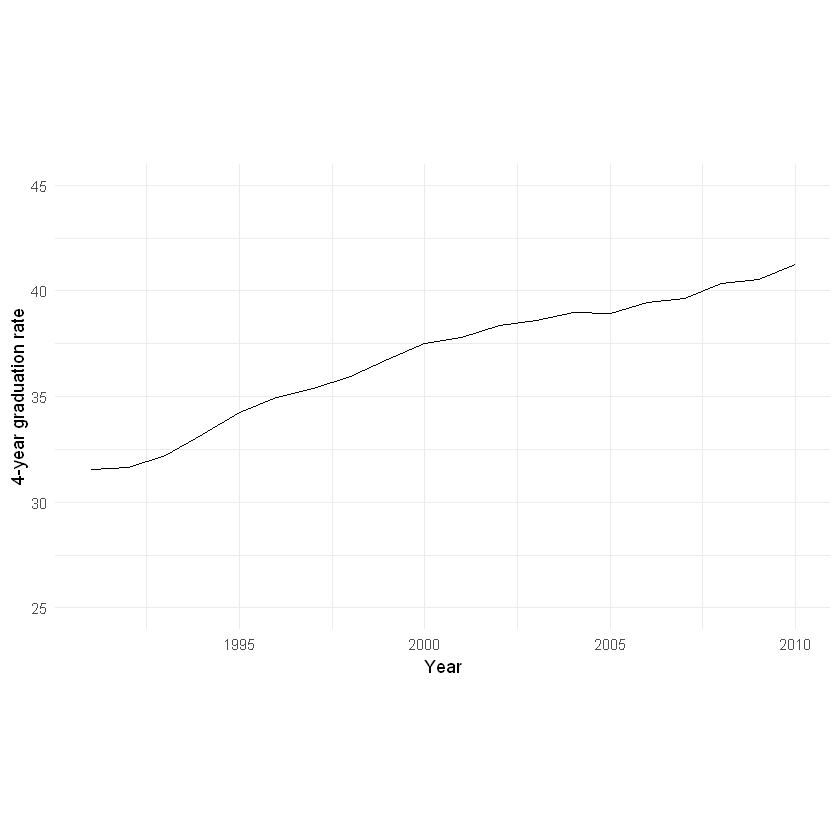

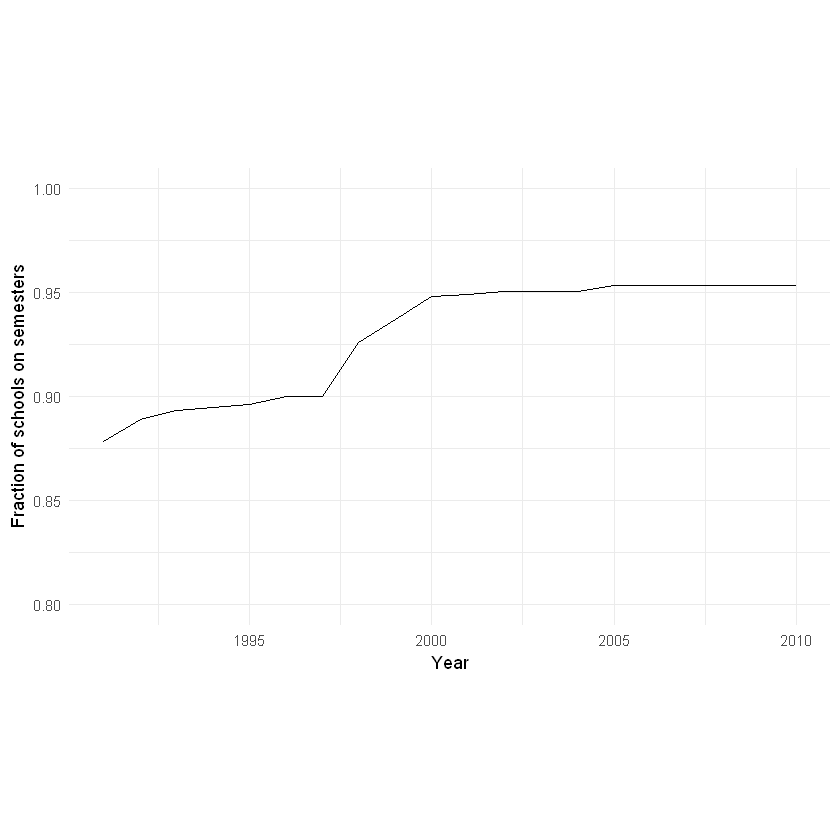

In [5]:
q3 <- ggplot(summary_figure_1, aes(x = year, y = avg_total_gradrate_4yr)) +
  geom_line() +
  labs(x = "Year",
       y = "4-year graduation rate") +
  theme_minimal() +
  theme(aspect.ratio = 0.6) +
  ylim(25, 45)

q4 <- ggplot(summary_figure_1, aes(x = year, y = semester_rate)) +
  geom_line() +
  labs(x = "Year",
       y = "Fraction of schools on semesters") +
  theme_minimal() +
  theme(aspect.ratio = 0.6) +
  ylim(0.8, 1)

print(q3)
print(q4)

In [6]:
#5

master <- master %>%
  mutate(women_rate = w_cohortsize / totcohortsize,
         white_rate = white_cohortsize / totcohortsize)

#散布図を作成する関数の定義
create_scatter_plot <- function(data, x_var, y_var,
                                point_size = 0.5, aspect_ratio = 0.75) {
  x_var <- ensym(x_var)
  y_var <- ensym(y_var)
  ggplot(data, aes(x = !!x_var, y = !!y_var)) +
    geom_point(size = point_size, na.rm = TRUE) +
    labs(x = as_label(x_var),
         y = as_label(y_var)) +
    theme_minimal() +
    theme(aspect.ratio = aspect_ratio)
}

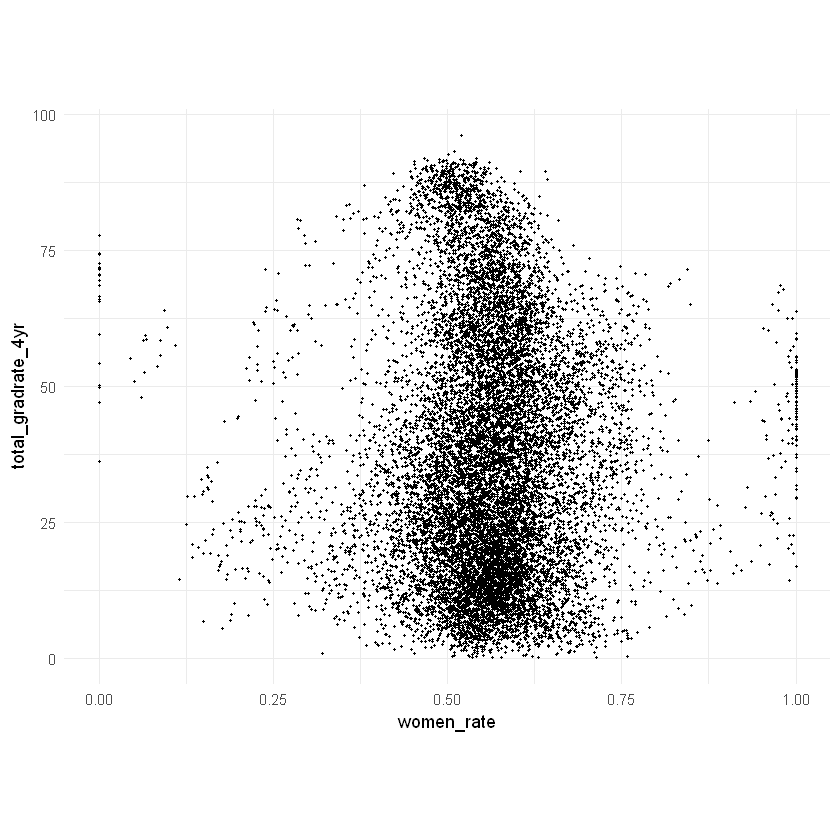

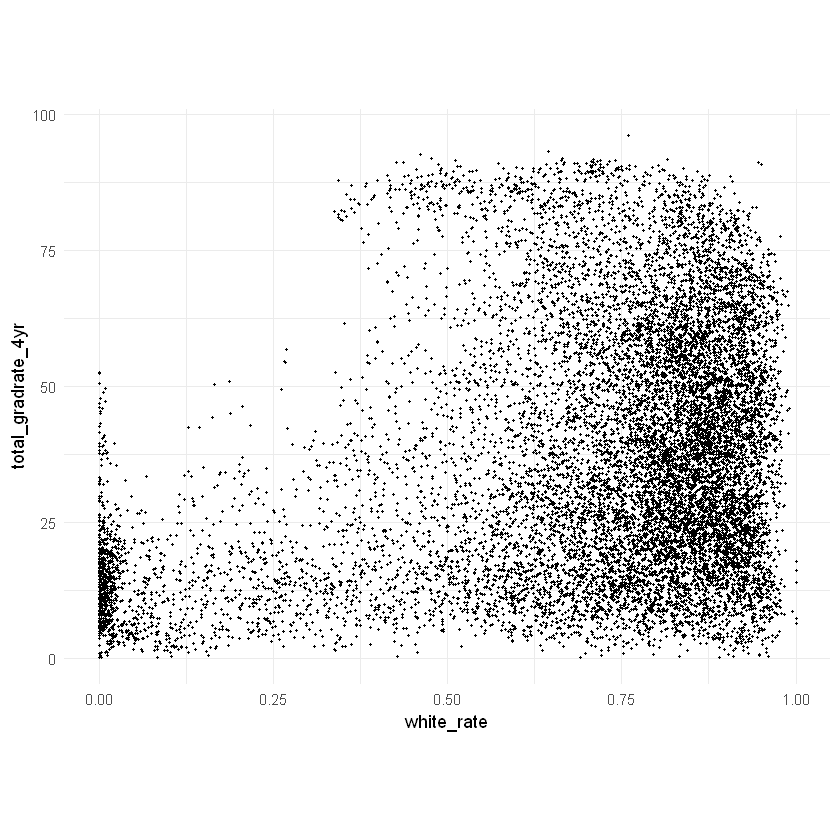

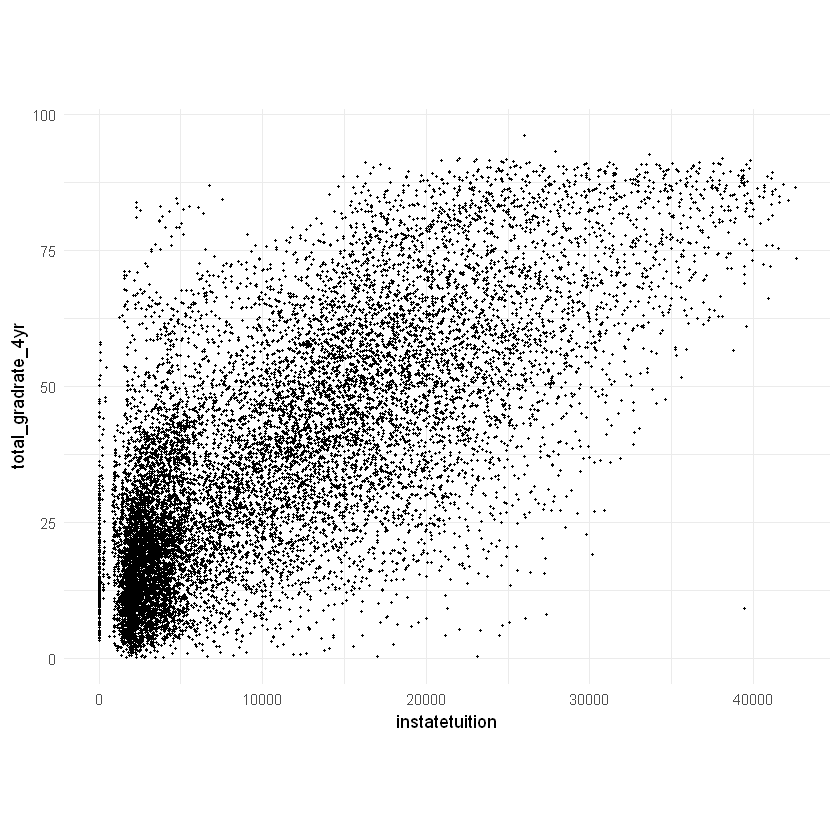

In [7]:
q5a <- create_scatter_plot(master, women_rate, total_gradrate_4yr)
q5b <- create_scatter_plot(master, white_rate, total_gradrate_4yr)
q5c <- create_scatter_plot(master, instatetuition, total_gradrate_4yr)

print(q5a)
print(q5b)
print(q5c)

In [8]:
#(b)1

#欠損値の処理
master_clean <- master %>%
  filter(!is.na(total_gradrate_4yr) & !is.na(semester))

model <- lm(total_gradrate_4yr ~ semester, data = master_clean)
stargazer(model, type = "text", keep.stat = "adj.rsq")


                Dependent variable:    
            ---------------------------
                total_gradrate_4yr     
---------------------------------------
semester             3.634***          
                      (0.756)          
                                       
Constant             33.676***         
                      (0.729)          
                                       
---------------------------------------
Adjusted R2            0.002           
Note:       *p<0.1; **p<0.05; ***p<0.01
